In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
import datetime
import json
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split

import joblib
import matplotlib.pyplot as plt
import math

2023-03-12 20:11:42.445815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 20:11:42.561174: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-12 20:11:42.945755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/maxpow/miniconda3/envs/tf/lib/:/home/maxpow/miniconda3/envs/tf/lib/
2023-03-12 20:11:42.945817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_pl

## Constants

In [2]:
# Hyperparams
mirror = False
MAX_FRAMES = 15
MAX_SEQ_LENGTH = MAX_FRAMES
N_PTS = 543
N_DIMS = 2
NUM_FEATURES = N_PTS*N_DIMS

START_FACE, END_FACE = (0, 468)
START_LHAND, END_LHAND = (468, 489)
START_POSE, END_POSE = (489, 522)
START_RHAND, END_RHAND = (522, 543)
LIPS_PTS = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]

PATIENCE = 16
BATCH_SIZE = 64
EPOCHS = 500

LR_START = 0.001
REDUCE_LR_PATIENCE = 4
REDUCE_LR_FACTOR = 0.2

X_npy_fname = f'X-15-keyframes-nearest-avg-std.npy'
y_npy_fname = f'y.npy'

COMP = os.environ.get('COMP_NAME', '?')
__file__ = os.path.abspath('')
MODEL_DIR = '/'.join((__file__).split('/')[:-1])
print(f'{MODEL_DIR=}')
METRIC_STR = '_xx_val_acc-'
MODEL_NAME = MODEL_DIR.split(METRIC_STR)[-1]

model_details = (
    f'{MODEL_NAME}'
    f'-key_frames_all_resize_nearest'
    f'-{MAX_FRAMES:02}_frames'
    f'-{N_PTS}_pts_per_frame'
    f'-{N_DIMS}_dims'
    f'-mirror' if mirror else ''
    f'-{BATCH_SIZE}_batch_size'
)

DATA_ROOT = '../data/'
DF_TRAIN =  f'{DATA_ROOT}train.csv'


MODEL_DIR='/home/maxpow/Workspace/kaggle-asl/kaggle-asl-signs'


## Data pre-processing

## Function Definitions

In [3]:
class CFG:
    data_path = DATA_ROOT
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic


## Start pre-processing here

In [4]:
train = pd.read_csv(DF_TRAIN)
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
X = np.load('X-15-keyframes-nearest-avg-std.npy')
y = np.load(y_npy_fname)
X_train = X
y_train = y

print(X_train.shape)
print(y_train.shape)

(94477, 15, 172)
(94477,)


## Model Definition

In [6]:
# CHANGED
# # RNN Model 
# > https://keras.io/examples/vision/video_classification/

# Utility for our sequence model.
def get_sequence_model(max_frames: int, num_features: int):
    n_classes = 250

    frame_features_input = tf.keras.Input((max_frames, num_features))

    # Data's dimensions were flattened so need to get the relevant pieces
    input_lhand = tf.keras.layers.Lambda(
        lambda x: x[:, :, START_LHAND*N_DIMS:END_LHAND*N_DIMS],
        output_shape=(MAX_FRAMES, (END_LHAND - START_LHAND), N_DIMS),
    )(frame_features_input)
    input_rhand = tf.keras.layers.Lambda(
        lambda x: x[:, :, START_RHAND*N_DIMS:END_RHAND*N_DIMS],
        output_shape=(MAX_FRAMES, (END_RHAND - START_RHAND), N_DIMS),
    )(frame_features_input)
    input_lips = tf.keras.layers.Lambda(
        lambda x: tf.gather(x, LIPS_PTS, axis=2),
        output_shape=(MAX_FRAMES, len(LIPS_PTS), N_DIMS),
    )(frame_features_input)
    
    ## RNN

    ## lhand + rhand + lips + avg_pose + avg_face + std_pose + std_face
    l = tf.keras.layers.GRU(512, return_sequences=True)(frame_features_input)
    l = tf.keras.layers.GRU(256)(l)
    # FCN
    l = tf.keras.layers.Dense(786)(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Activation('relu')(l)
    l = tf.keras.layers.Dropout(0.2)(l)
    l = tf.keras.layers.Dense(393)(l)
    l = tf.keras.layers.BatchNormalization()(l)
    l = tf.keras.layers.Activation('relu')(l)
    l = tf.keras.layers.Dropout(0.2)(l)
   

    x = tf.keras.layers.Dense(512, activation='relu')(l)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

    rnn_model = tf.keras.Model([frame_features_input,], output)

    rnn_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Nadam(
            learning_rate=LR_START,
        ),
        metrics=['accuracy'],
    )
    return rnn_model


In [7]:
# # # RNN Model 
# # > https://keras.io/examples/vision/video_classification/

# # Utility for our sequence model.
# def get_sequence_model(max_frames: int, num_features: int):
#     n_classes = 250

#     frame_features_input = tf.keras.Input((max_frames, num_features))

#     # Data's dimensions were flattened so need to get the relevant pieces
#     input_lhand = tf.keras.layers.Lambda(
#         lambda x: x[:, :, START_LHAND*N_DIMS:END_LHAND*N_DIMS],
#         output_shape=(MAX_FRAMES, (END_LHAND - START_LHAND), N_DIMS),
#     )(frame_features_input)
#     input_rhand = tf.keras.layers.Lambda(
#         lambda x: x[:, :, START_RHAND*N_DIMS:END_RHAND*N_DIMS],
#         output_shape=(MAX_FRAMES, (END_RHAND - START_RHAND), N_DIMS),
#     )(frame_features_input)
#     input_lips = tf.keras.layers.Lambda(
#         lambda x: tf.gather(x, LIPS_PTS, axis=2),
#         output_shape=(MAX_FRAMES, len(LIPS_PTS), N_DIMS),
#     )(frame_features_input)
    
#     ## RNN

#     ## lhand + lips
#     concat_lhand = tf.keras.layers.Concatenate()([input_lhand, input_lips])
#     l = tf.keras.layers.GRU(512, return_sequences=True)(concat_lhand)
#     l = tf.keras.layers.GRU(256)(l)
#     # FCN
#     l = tf.keras.layers.Dense(786)(l)
#     l = tf.keras.layers.BatchNormalization()(l)
#     l = tf.keras.layers.Activation('relu')(l)
#     l = tf.keras.layers.Dropout(0.2)(l)
#     l = tf.keras.layers.Dense(393)(l)
#     l = tf.keras.layers.BatchNormalization()(l)
#     l = tf.keras.layers.Activation('relu')(l)
#     l = tf.keras.layers.Dropout(0.2)(l)

#     ## rhand
#     concat_rhand = tf.keras.layers.Concatenate()([input_rhand, input_lips])
#     r = tf.keras.layers.GRU(512, return_sequences=True)(concat_rhand)
#     r = tf.keras.layers.GRU(256)(r)
#     # FCN
#     r = tf.keras.layers.Dense(786)(r)
#     r = tf.keras.layers.BatchNormalization()(r)
#     r = tf.keras.layers.Activation('relu')(r)
#     r = tf.keras.layers.Dropout(0.2)(r)
#     r = tf.keras.layers.Dense(393)(r)
#     r = tf.keras.layers.BatchNormalization()(r)
#     r = tf.keras.layers.Activation('relu')(r)
#     r = tf.keras.layers.Dropout(0.2)(r)


    
#     concat_hands = tf.keras.layers.Concatenate()([l, r])
#     x = tf.keras.layers.Dense(783)(concat_hands)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
   

#     x = tf.keras.layers.Dense(512, activation='relu')(x)
#     x = tf.keras.layers.Dense(512)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Dropout(0.3)(x)

#     x = tf.keras.layers.Flatten()(x)
#     output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

#     rnn_model = tf.keras.Model([frame_features_input,], output)

#     rnn_model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer=tf.keras.optimizers.Nadam(
#             learning_rate=LR_START,
#         ),
#         metrics=['accuracy'],
#     )
#     return rnn_model


In [8]:
model = get_sequence_model(max_frames=MAX_FRAMES, num_features=X_train.shape[2])
print(model.summary())

2023-03-12 20:12:05.769517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 20:12:05.773233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 20:12:05.773381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 20:12:05.773656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 172)]         0         
                                                                 
 gru (GRU)                   (None, 15, 512)           1053696   
                                                                 
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 786)               202002    
                                                                 
 batch_normalization (BatchN  (None, 786)              3144      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 786)               0         
                                                             

## Model Training

### Function definitions

In [9]:

def run_experiment(
    model,
    train_data,
    train_labels,
    validation_data = None,
    validation_split: int = 0.2,
    model_path: str = 'temp',
    epochs: int = 10,
    batch_size: int = 128,
    monitor_metric: str = 'val_accuracy',
    patience: int = 6,
):
    from Slack import SlackCallback
    slack_callback = SlackCallback(
        token=os.environ['SLACK_BOT_TOKEN'],
        start_message=(
            f'Model starting on {COMP=} for {EPOCHS=}\n'
            f'{model_details=}'
        ),
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            model_path,
            save_weights_only=True,
            save_best_only=True,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor_metric,
            patience=patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=(
                'logs/fit/'
                + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                + f'-{model_details}'
            ),
            histogram_freq=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=REDUCE_LR_FACTOR,
            patience=REDUCE_LR_PATIENCE,
        ),
        slack_callback,
    ]
        
    fit_params = dict(
        x=train_data,
        y=train_labels,
        epochs=epochs,
        batch_size=batch_size,
    )
    if validation_data:
        fit_params['validation_data'] = validation_data
    else:
        fit_params['validation_split'] = validation_split

    history = model.fit(
        **fit_params,
        callbacks=callbacks,
    )

    return model, history

### Training starts here

Epoch 1/500


2023-03-12 20:12:18.651579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1329/1329 [==============================] - 45s 32ms/step - loss: 4.6976 - accuracy: 0.0591 - val_loss: 4.7315 - val_accuracy: 0.0700 - lr: 0.0010
Epoch 2/500
1329/1329 [==============================] - 40s 30ms/step - loss: 3.2744 - accuracy: 0.2286 - val_loss: 3.0590 - val_accuracy: 0.2665 - lr: 0.0010
Epoch 3/500
1329/1329 [==============================] - 41s 31ms/step - loss: 2.7154 - accuracy: 0.3373 - val_loss: 2.9977 - val_accuracy: 0.2804 - lr: 0.0010
Epoch 4/500
1329/1329 [==============================] - 41s 31ms/step - loss: 2.3543 - accuracy: 0.4136 - val_loss: 3.5057 - val_accuracy: 0.2412 - lr: 0.0010
Epoch 5/500
1329/1329 [==============================] - 43s 32ms/step - loss: 2.1038 - accuracy: 0.4711 - val_loss: 2.6753 - val_accuracy: 0.3449 - lr: 0.0010
Epoch 6/500
1329/1329 [==============================] - 41s 31ms/step - loss: 1.9224 - accuracy: 0.5105 - val_loss: 1.9911 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 7/500
1329/1329 [=============================

/home/maxpow/miniconda3/envs/tf/lib/python3.9/site-packages/slack_sdk/web/internal_utils.py:450: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


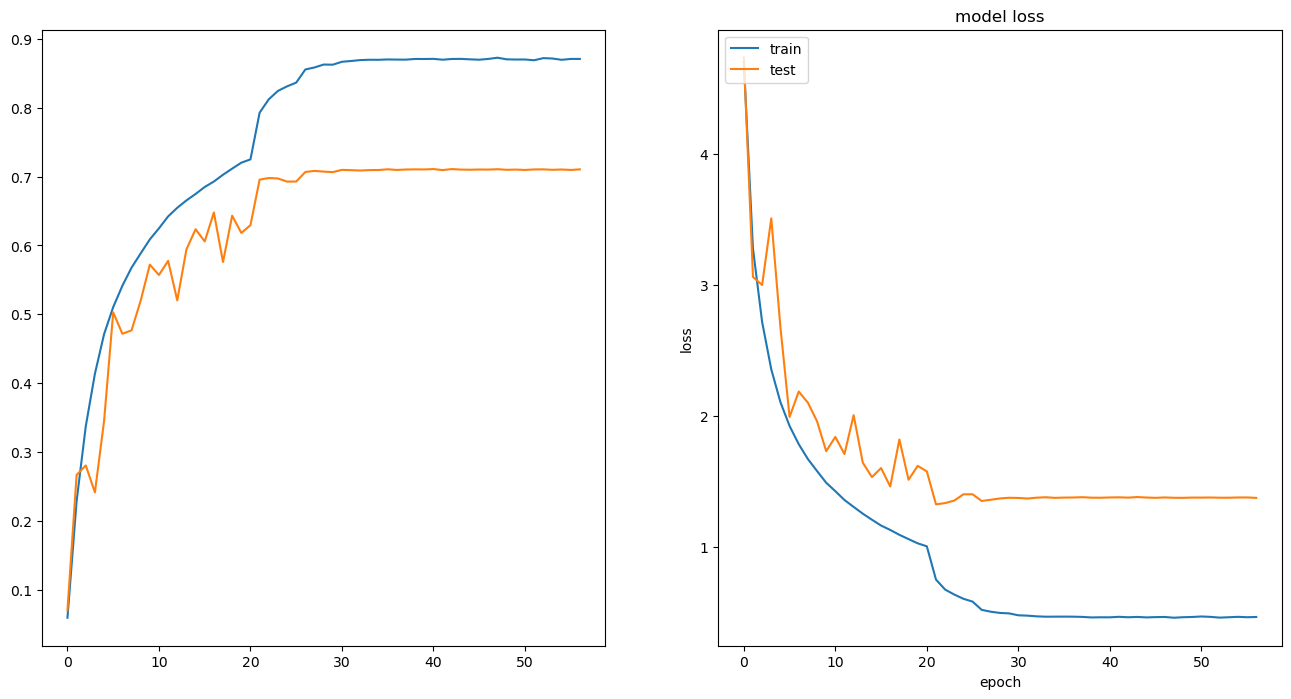

INFO:tensorflow:Assets written to: ram://b4c8fa9c-cc03-4109-b986-88f783ffc708/assets


INFO:tensorflow:Assets written to: ram://b4c8fa9c-cc03-4109-b986-88f783ffc708/assets


NameError: name 'X_val' is not defined

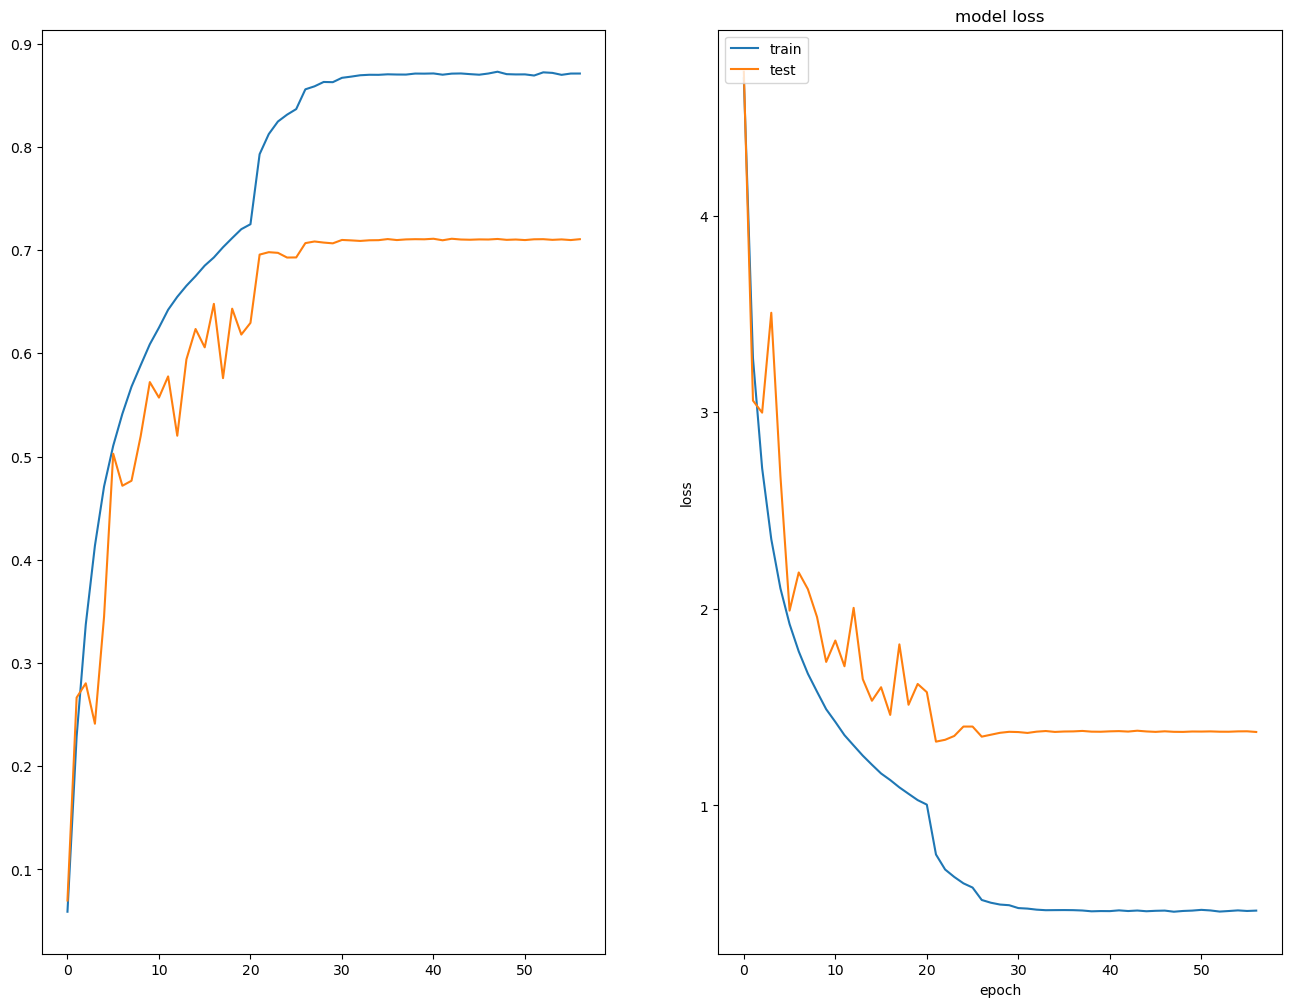

In [10]:
# ## Experiment
model_details += f'-{model.count_params()}_model_params_nearest_avg_std'
model, history = run_experiment(
    model=model,
    train_data=(X_train,),
    train_labels=y_train,
    validation_data=None,
    validation_split=0.1,
    model_path=f'model_nearest_with_avg_std.h5',
    batch_size=64,
    epochs=500,
    patience=PATIENCE,
)

joblib.dump(history, f'{MODEL_DIR}/history-{model_details}.gz')


# Plot Results
# summarize history for accuracy
fig, (ax_acc, ax_loss) = plt.subplots(ncols=2, figsize=(16,12))

ax_acc.plot(history.history['accuracy'])
ax_acc.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax_loss.plot(history.history['loss'])
ax_loss.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

fig.savefig(f'{MODEL_DIR}/acc_loss-{model_details}.png')
results = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
val_loss, val_acc = results
print(f'{val_loss=}')
print(f'{val_acc*100:2.0f}_val_acc')

In [11]:
model.save('model_tf',save_format='tf')
loaded_model = tf.keras.models.load_model('./model_tf')


INFO:tensorflow:Assets written to: model_tf/assets


INFO:tensorflow:Assets written to: model_tf/assets


## Generate TFlite Model for Submission

In [12]:
# Load model weights
model_weights_path = 'model_nearest_with_avg_std.h5'
model.load_weights(model_weights_path)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 172)]         0         
                                                                 
 gru (GRU)                   (None, 15, 512)           1053696   
                                                                 
 gru_1 (GRU)                 (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 786)               202002    
                                                                 
 batch_normalization (BatchN  (None, 786)              3144      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 786)               0         
                                                             

In [71]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        """
        Given x_in of shape (n, 543, 3), return a new x which uses 15 key_frames so the shape would be (1, 15, 543*2)
        """
        def tf_nan_mean(x, axis=0):
            return tf.math.reduce_mean(x, axis, keepdims=True)

        def tf_nan_std(x, axis=0):
            return tf.math.reduce_std(x, axis=axis, keepdims=True)  
        
        def convert_row(data):
            START_FACE, END_FACE = (0, 468)
            START_LHAND, END_LHAND = (468, 489)
            START_POSE, END_POSE = (489, 522)
            START_RHAND, END_RHAND = (522, 543)
            LIPS_PTS = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
            LANDMARK_PTS = len(LIPS_PTS) + (END_LHAND - START_LHAND) + (END_RHAND - START_RHAND)
            avg_sets = [(START_FACE, END_FACE),(START_POSE, END_POSE)]
            
            data = data[:,:,:N_DIMS]
            x_list = [tf_nan_mean(data[:, avg_set[0]:avg_set[0]+avg_set[1],:],axis=1) for avg_set in avg_sets]
            x_list += ([tf_nan_std(data[:, avg_set[0]:avg_set[0]+avg_set[1],:],axis=1) for avg_set in avg_sets])
            x_list.append(tf.gather(data, LIPS_PTS, axis=1))
            x_list.append(data[:,START_LHAND:END_LHAND,:])
            x_list.append(data[:,START_RHAND:END_RHAND,:])
            x = tf.concat(x_list, 1)
            
            # x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
            
            ## Frame Aggregation
            x = tf.image.resize(
                x, # tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)),
                size=(MAX_FRAMES, LANDMARK_PTS + len(avg_sets)*2),
                method='nearest', #DEFAULT
            )
            # (MAX_FRAMES, num_landmark_pts + avg_set*2, 2)
            x = tf.reshape(x, (MAX_FRAMES, x.shape[1] * x.shape[2]))
            return x
        
        data_key_frames = convert_row( x_in)
        data_key_frames = tf.expand_dims(data_key_frames, axis=0)
        return data_key_frames

print(FeatureGen()(load_relevant_data_subset(f'{CFG.data_path}{train.iloc[0].path}')))

tf.Tensor(
[[[ 0.5098687   0.34322077  0.5044036  ...  0.39958185  0.38579622
    0.4011007 ]
  [ 0.5099857   0.34265283  0.5294322  ...  0.37769613  0.43907768
    0.37987   ]
  [ 0.5142179   0.34298542  0.5305949  ...  0.38334605  0.4382043
    0.38134953]
  ...
  [ 0.54557896  0.34427667         nan ...         nan         nan
           nan]
  [ 0.54500914  0.34417295         nan ...         nan         nan
           nan]
  [ 0.5439946   0.3430536   0.39194506 ...  0.6437988  -0.03181136
    0.62707704]]], shape=(1, 15, 172), dtype=float32)


In [72]:
class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ASL model 
    """

    def __init__(self, asl_model):
        """
        Initializes the TFLiteModel with the specified feature generation model and main model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = FeatureGen()
        self.asl_model   = asl_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [num_frames, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.asl_model(x)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}
model_path = "model.tflite"

In [73]:
tflite_keras_model = TFLiteModel(asl_model=model)
prediction = tflite_keras_model(load_relevant_data_subset(f'{CFG.data_path}{train.iloc[0].path}'))["outputs"]

print(index_label[tf.argmax(prediction, axis=1).numpy()[0]])
print(f'{train.iloc[0].sign}')

TV
blow


In [63]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()

# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvct3gylu/assets


INFO:tensorflow:Assets written to: /tmp/tmpvct3gylu/assets
2023-03-12 20:01:03.905709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-12 20:01:03.905730: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-12 20:01:03.906165: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvct3gylu
2023-03-12 20:01:03.916919: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-12 20:01:03.916938: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvct3gylu
2023-03-12 20:01:03.951623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-12 20:01:03.973791: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-12 20:01:04.101217: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [74]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
for i in range(100):
    # frames = load_relevant_data_subset(f'/kaggle/input/asl-signs/{train.iloc[i].path}')
    frames = load_relevant_data_subset(f'{CFG.data_path}{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")

Predicted label: blow, Actual Label: blow
Predicted label: wait, Actual Label: wait
Predicted label: zebra, Actual Label: cloud
Predicted label: bird, Actual Label: bird
Predicted label: owie, Actual Label: owie
Predicted label: duck, Actual Label: duck
Predicted label: minemy, Actual Label: minemy
Predicted label: brother, Actual Label: lips
Predicted label: flower, Actual Label: flower
Predicted label: cowboy, Actual Label: time
Predicted label: beside, Actual Label: vacuum
Predicted label: better, Actual Label: apple
Predicted label: brother, Actual Label: puzzle
Predicted label: mitten, Actual Label: mitten
Predicted label: finger, Actual Label: there
Predicted label: dry, Actual Label: dry
Predicted label: happy, Actual Label: shirt
Predicted label: owl, Actual Label: owl
Predicted label: yellow, Actual Label: yellow
Predicted label: shower, Actual Label: time
Predicted label: wake, Actual Label: not
Predicted label: brother, Actual Label: zipper
Predicted label: dirty, Actual Lab

In [75]:
def genAccuracy(df):
    num_samples = df.shape[0]
    num_correct = 0
    for i in tqdm(range(num_samples)):    
        prediction = prediction_fn(inputs=load_relevant_data_subset(f'{CFG.data_path}{df.iloc[i].path}'))
        label_pred = np.argmax(prediction["outputs"])
        label_actual = df.iloc[i].label
        num_correct += int(label_pred == label_actual)
    return num_correct / num_samples


In [ ]:
# Validation accuracy 
df_train, df_validation = train_test_split(train, test_size=0.1, random_state=27)
print(df_train.shape)
print(df_validation.shape)

In [77]:
val_acc = genAccuracy(train.sample(100))
print(val_acc)

100%|███████████████████████████████████████| 100/100 [00:05<00:00, 19.81it/s]

0.6


In [ ]:
with open('/kaggle/working/models/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/models/model.tflite